# Acoustic Anomaly Detection based on Images with Azure AutoML for Images

## 03. Audio Analytics

<img src='https://github.com/retkowsky/CustomVision_Datasets/blob/master/anomaly.png?raw=true' width = 600>

<div class="alert alert-info"> <b> In this notebook We will generate some audio analytics</b></div>

Serge Retkowsky | serge.retkowsky@microsoft.com | 25-Oct-2022 | V3

In [1]:
import matplotlib.pyplot as plt
import librosa, librosa.display, IPython.display as ipd
import numpy as np
import wave
import os
import os.path, time
import seaborn
import glob
import shutil
import urllib.request
import audioread
import pandas as pd
import shutil
import sys

from pathlib import Path
from os.path import getsize
from scipy.io import wavfile as wav
from zipfile import ZipFile
from pathlib import Path
from datetime import datetime

%matplotlib inline

In [2]:
sys.version

'3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'

In [3]:
import datetime

print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2022-10-25 13:01:32


In [4]:
def file_exist(file):
    """
    Test if a file exist
    """
    path = Path(file)
    if path.is_file() == True:
        print("OK: file", file, "exists")

    else:
        print('Error: file', file, "does not exists")

## Analysing an audio file

A sound signal is produced by variations in air pressure. We can measure the intensity of the pressure variations and plot those measurements over time.
Sound signals often repeat at regular intervals so that each wave has the same shape. **The height shows the intensity of the sound and is known as the amplitude.**

<div class="alert alert-info">
    
- **Time series**<br>
Typically an audio signal, denoted by y, and represented as a one-dimensional numpy.ndarray of floating-point values. y[t] corresponds to amplitude of the waveform at sample t.

- **sampling rate**<br>
The (positive integer) number of samples per second of a time series. This is denoted by an integer variable sr.

- **frame**<br>
A short slice of a time series used for analysis purposes. This usually corresponds to a single column of a spectrogram matrix.

- **window**<br>
A vector or function used to weight samples within a frame when computing a spectrogram.

- **frame length**<br>
The (positive integer) number of samples in an analysis window (or frame). This is denoted by an integer variable n_fft.

- **hop length**<br>
The number of samples between successive frames, e.g., the columns of a spectrogram. This is denoted as a positive integer hop_length.

- **window length**<br>
The length (width) of the window function (e.g., Hann window). Note that this can be smaller than the frame length used in a short-time Fourier transform. Typically denoted as a positive integer variable win_length.

- **spectrogram**<br>
A matrix S where the rows index frequency bins, and the columns index frames (time). Spectrograms can be either real-valued or complex-valued. By convention, real-valued spectrograms are denoted as numpy.ndarrays S, while complex-valued STFT matrices are denoted as D.
    </div>

In [5]:
audiofileOK = 'audio_samples/OK/machine_OK_1.wav'
audiofileKO = 'audio_samples/KO/machine_KO_1.wav'

In [6]:
file_exist(audiofileOK)

OK: file audio_samples/OK/machine_OK_1.wav exists


In [7]:
file_exist(audiofileKO)

OK: file audio_samples/KO/machine_KO_1.wav exists


In [8]:
def audio_metadata(audiofile):
    """
    Audio metadata generation
    """
    import os.path
    import time
    import audio_metadata

    lastmodifdate = time.ctime(os.path.getmtime(audiofile))
    creationdate = time.ctime(os.path.getctime(audiofile))
    audiofilemetadata = audio_metadata.load(audiofile)
    audioformat = audiofilemetadata['streaminfo']['audio_format']
    bitdepth = audiofilemetadata['streaminfo']['bit_depth']
    bitrate = audiofilemetadata['streaminfo']['bitrate']
    nbchannels = audiofilemetadata['streaminfo']['channels']
    duration = audiofilemetadata['streaminfo']['duration']
    samplerate = audiofilemetadata['streaminfo']['sample_rate']
    audiofilesize = audiofilemetadata['filesize']

    print("===== Audio Statistics =====\n")
    print("Audio File:\t", audiofile)
    print("Modified Date:\t", lastmodifdate)
    print("Creation Date:\t", creationdate)
    print("File Size:\t", audiofilesize)
    print("Audio Format:\t", audioformat)
    print("Bit Depth:\t", bitdepth)
    print("Bit Rate:\t", bitrate)
    print("Sampling Rate:\t", samplerate)
    print("Nb of Channels:\t", nbchannels)
    print("Duration:\t", duration)
    print()
    return {
        'audiofile': audiofile,
        'lastmodifdate': lastmodifdate,
        'creationdate': creationdate,
        'audiofilesize': audiofilesize,
        'audioformat': audioformat,
        'bitdepth': bitdepth,
        'bitrate': bitrate,
        'samplerate': samplerate,
        'nbchannels': nbchannels,
        'duration': duration
    }

In [9]:
audio_metadata(audiofileOK)

===== Audio Statistics =====

Audio File:	 audio_samples/OK/machine_OK_1.wav
Modified Date:	 Tue Oct 25 12:53:50 2022
Creation Date:	 Tue Oct 25 12:53:50 2022
File Size:	 1234844
Audio Format:	 WAVEAudioFormat.PCM
Bit Depth:	 16
Bit Rate:	 1411200
Sampling Rate:	 44100
Nb of Channels:	 2
Duration:	 7.0



{'audiofile': 'audio_samples/OK/machine_OK_1.wav',
 'lastmodifdate': 'Tue Oct 25 12:53:50 2022',
 'creationdate': 'Tue Oct 25 12:53:50 2022',
 'audiofilesize': 1234844,
 'audioformat': <WAVEAudioFormat.PCM>,
 'bitdepth': 16,
 'bitrate': 1411200,
 'samplerate': 44100,
 'nbchannels': 2,
 'duration': 7.0}

In [10]:
audio_metadata(audiofileKO)

===== Audio Statistics =====

Audio File:	 audio_samples/KO/machine_KO_1.wav
Modified Date:	 Tue Oct 25 12:54:02 2022
Creation Date:	 Tue Oct 25 12:54:02 2022
File Size:	 1234844
Audio Format:	 WAVEAudioFormat.PCM
Bit Depth:	 16
Bit Rate:	 1411200
Sampling Rate:	 44100
Nb of Channels:	 2
Duration:	 7.0



{'audiofile': 'audio_samples/KO/machine_KO_1.wav',
 'lastmodifdate': 'Tue Oct 25 12:54:02 2022',
 'creationdate': 'Tue Oct 25 12:54:02 2022',
 'audiofilesize': 1234844,
 'audioformat': <WAVEAudioFormat.PCM>,
 'bitdepth': 16,
 'bitrate': 1411200,
 'samplerate': 44100,
 'nbchannels': 2,
 'duration': 7.0}

## Playing the audio file

### Equipment sound: OK

In [11]:
from IPython.display import Audio

Audio(audiofileOK)

### Equipment sound: Not OK (anomaly)

In [12]:
Audio(audiofileKO)

In [13]:
y, sr = librosa.load(audiofileOK)
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
print("Tempo is =", tempo)

Tempo is = 89.10290948275862


In [14]:
y, sr = librosa.load(audiofileKO)
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
print("Tempo is =", tempo)

Tempo is = 172.265625


## Signal

A signal is a variation of a certain quantity over time.
For audio, the quantity that varies is the atmospheric pressure.<br><br>
How do we capture this information digitally?
We can take samples of the air pressure over time. The frequency at which we sample the data can vary, but is most often 44.1 kHz, or 44,100 samples per second. 

<img src="https://th.bing.com/th/id/R.639c075074d8388e0a3892ca073a7522?rik=JGcvXvzzDZKDUA&riu=http%3a%2f%2fletstalkscience.ca%2fsites%2fdefault%2ffiles%2fstyles%2fwidth_800px%2fpublic%2f2020-01%2fAmplitude_loud_and_quiet_sounds.png%3fitok%3dgadJLBbC&ehk=R5F5Jl2ugGKrgbug5Yc5EjLY0Zr0Ksl4lGrVtzkO2ZI%3d&risl=&pid=ImgRaw&r=0&sres=1&sresct=1" width=600>

In [15]:
samplesOK, sampling_rateOK = librosa.load(audiofileOK,
                                          sr=None,
                                          mono=True,
                                          offset=0.0,
                                          duration=None)
durationOK = len(samplesOK) / sampling_rateOK
print("Samples Length:", len(samplesOK))
print("Sampling Rate:", sampling_rateOK)
print("Duration:", durationOK)

Samples Length: 308700
Sampling Rate: 44100
Duration: 7.0


In [16]:
fnameOK = os.path.splitext(os.path.basename(audiofileOK))
imagefnameOK = fnameOK[0]

In [17]:
MYDIR = 'results'

if os.path.isdir(MYDIR) == True:
    print("Directory", MYDIR, "exists. So let's use it.")
    
if os.path.isdir(MYDIR) == False:
    print("Directory not exists. Creating directory... ", MYDIR)
    os.mkdir(MYDIR)
    print("Done.")

Directory results exists. So let's use it.


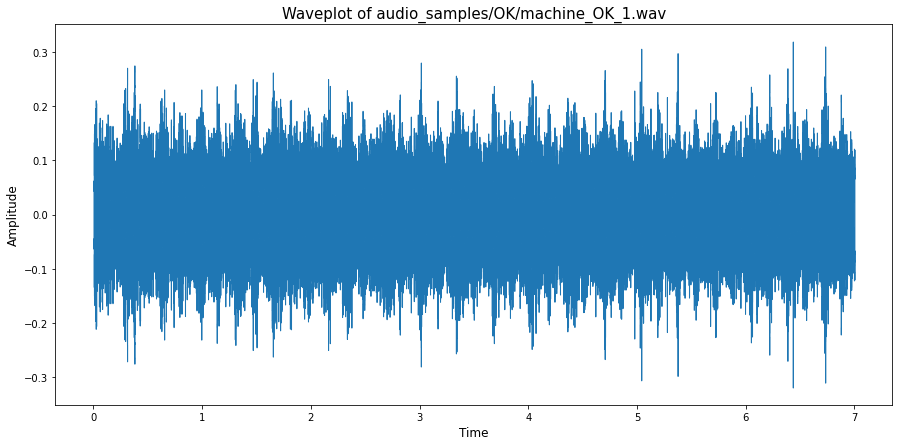

In [18]:
plt.figure(figsize=(15, 7))

librosa.display.waveshow(samplesOK, sr=sampling_rateOK)
title = "Waveplot of " + audiofileOK
plt.title(title, fontdict=dict(size=15))
plt.xlabel('Time', fontdict=dict(size=12))
plt.ylabel('Amplitude', fontdict=dict(size=12))

fnameOK = os.path.splitext(os.path.basename(audiofileOK))
outputfile1 = 'results/' + imagefnameOK + '_waveplot.jpg'

plt.savefig(outputfile1, dpi=300)
plt.show()

In [19]:
samplesKO, sampling_rateKO = librosa.load(audiofileKO,
                                          sr=None,
                                          mono=True,
                                          offset=0.0,
                                          duration=None)
durationKO = len(samplesKO) / sampling_rateKO
print("Samples Length:", len(samplesKO))
print("Sampling Rate:", sampling_rateKO)
print("Duration:", durationKO)

Samples Length: 308700
Sampling Rate: 44100
Duration: 7.0


In [20]:
fnameKO = os.path.splitext(os.path.basename(audiofileKO))
imagefnameKO = fnameKO[0]

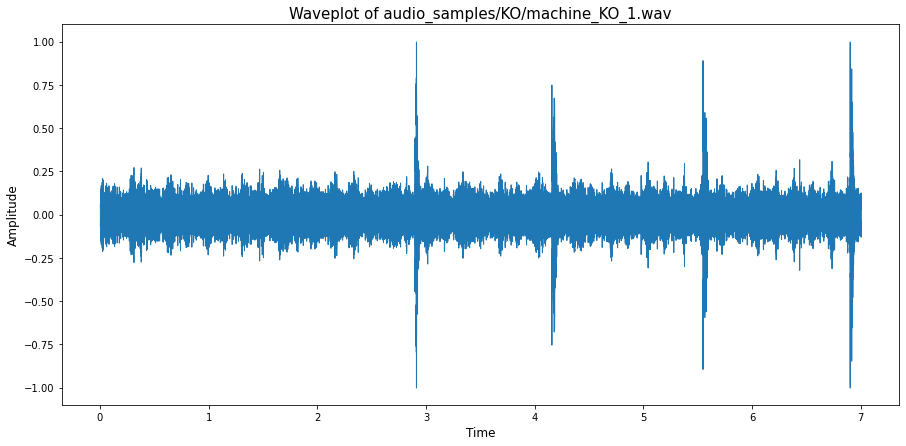

In [21]:
plt.figure(figsize=(15, 7))

librosa.display.waveshow(samplesKO, sr=sampling_rateKO)
title = "Waveplot of " + audiofileKO
plt.title(title, fontdict=dict(size=15))
plt.xlabel('Time', fontdict=dict(size=12))
plt.ylabel('Amplitude', fontdict=dict(size=12))

fnameKO = os.path.splitext(os.path.basename(audiofileKO))
outputfile1 = 'results/' + imagefnameKO + '_waveplot.jpg'

plt.savefig(outputfile1, dpi=300)
plt.show()

## Spectrum

**An audio signal is composed of several sound waves with a single frequency**. When we sample the signal over time, we capture only the resulting amplitudes. The Fourier transform is a mathematical formula that allows us to break down a signal into its individual frequencies and the amplitude of the frequency. <br>

<div class="alert alert-info"> 
<b>In other words, it converts the signal from the time domain into the frequency domain. <br><br>
    The result is called a spectrum.</b></div>

<img src="https://www.cbcity.de/wp-content/uploads/2014/04/FFT1.png" width = 800>

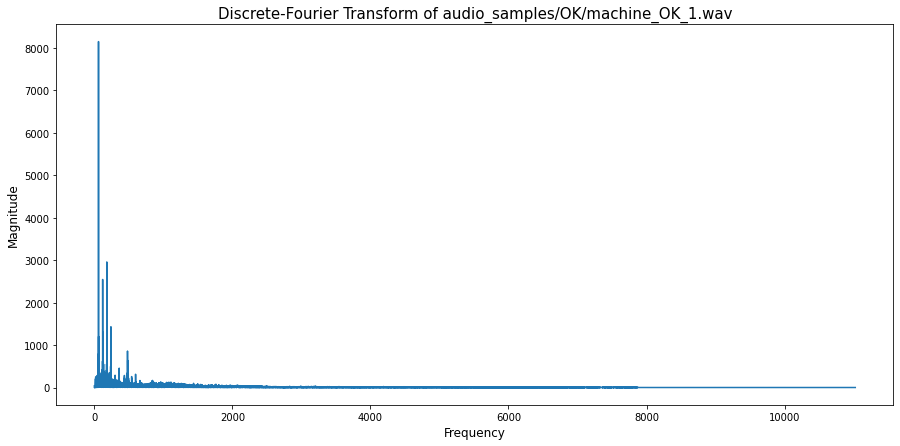

In [22]:
plt.figure(figsize=(15, 7))

# Creating a Discrete-Fourier Transform with our FFT algorithm
fast_fourier_transfOK = np.fft.fft(samplesOK)

# Magnitudes indicate the contribution of each frequency
magnitudeOK = np.abs(fast_fourier_transfOK)

# mapping the magnitude to the relative frequency bins
frequencyOK = np.linspace(0, sr, len(magnitudeOK))

# We only need the first half of the magnitude and frequency
left_magOK = magnitudeOK[:int(len(magnitudeOK) / 2)]
left_freqOK = frequencyOK[:int(len(frequencyOK) / 2)]

title = "Discrete-Fourier Transform of " + audiofileOK
plt.plot(left_freqOK, left_magOK)
plt.title(title, fontdict=dict(size=15))
plt.xlabel('Frequency', fontdict=dict(size=12))
plt.ylabel('Magnitude', fontdict=dict(size=12))

fnameOK = os.path.splitext(os.path.basename(audiofileOK))
outputfile2 = 'results/' + imagefnameOK + '_FFT.jpg'

plt.savefig(outputfile2, dpi=300)
plt.show()

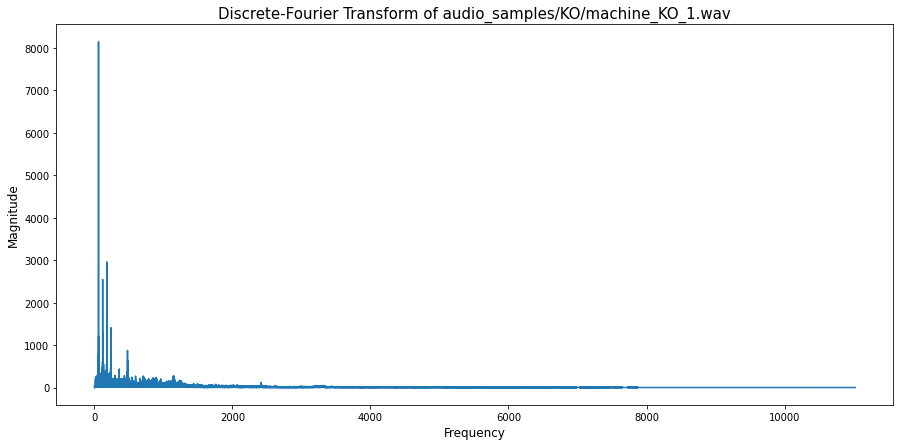

In [23]:
plt.figure(figsize=(15, 7))

# Creating a Discrete-Fourier Transform with our FFT algorithm
fast_fourier_transfKO = np.fft.fft(samplesKO)

# Magnitudes indicate the contribution of each frequency
magnitudeKO = np.abs(fast_fourier_transfKO)

# mapping the magnitude to the relative frequency bins
frequencyKO = np.linspace(0, sr, len(magnitudeKO))

# We only need the first half of the magnitude and frequency
left_magKO = magnitudeKO[:int(len(magnitudeKO) / 2)]
left_freqKO = frequencyKO[:int(len(frequencyKO) / 2)]

title = "Discrete-Fourier Transform of " + audiofileKO
plt.plot(left_freqKO, left_magKO)
plt.title(title, fontdict=dict(size=15))
plt.xlabel('Frequency', fontdict=dict(size=12))
plt.ylabel('Magnitude', fontdict=dict(size=12))

fnameKO = os.path.splitext(os.path.basename(audiofileKO))
outputfile2 = 'results/' + imagefnameKO + '_FFT.jpg'

plt.savefig(outputfile2, dpi=300)
plt.show()

## Spectogram

Since a signal produces different sounds as it varies over time, its constituent frequencies also vary with time. In other words, its **Spectrum varies with time.**<br><br>

<div class="alert alert-info"><b> A Spectrogram of a signal plots its Spectrum over time and is like a ‘photograph’ of the signal.
    </b></div>

It plots Time on the x-axis and Frequency on the y-axis. It is as though we took the Spectrum again and again at different instances in time, and then joined them all together into a single plot.<br><br>
It uses different colors to indicate the Amplitude or strength of each frequency. The brighter the color the higher the energy of the signal. **Each vertical ‘slice’ of the Spectrogram is essentially the Spectrum of the signal at that instant in time and shows how the signal strength is distributed in every frequency found in the signal at that instant.**

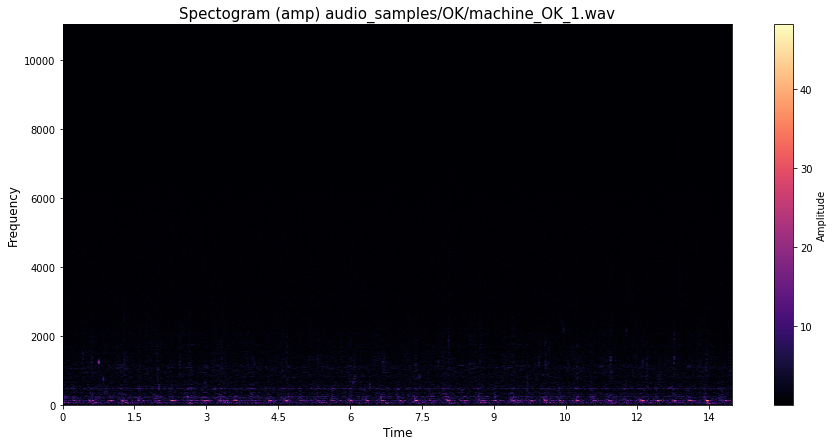

In [24]:
plt.figure(figsize=(15, 7))

# this is the number of samples in a window per fft
n_fft = 2048
# The amount of samples we are shifting after each fft
hop_length = 512
# Short-time Fourier Transformation on our audio data
audio_stftOK = librosa.core.stft(samplesOK, hop_length=hop_length, n_fft=n_fft)
# gathering the absolute values for all values in our audio_stft
spectrogramOK = np.abs(audio_stftOK)

title = "Spectogram (amp) " + audiofileOK
librosa.display.specshow(spectrogramOK,
                         sr=sr,
                         x_axis='time',
                         y_axis='hz',
                         hop_length=hop_length)
plt.colorbar(label='Amplitude')
plt.title(title, fontdict=dict(size=15))
plt.xlabel('Time', fontdict=dict(size=12))
plt.ylabel('Frequency', fontdict=dict(size=12))

outputfile3 = 'results/' + imagefnameOK + '_spectogram_amp.jpg'
plt.savefig(outputfile3, dpi=300)
plt.show()

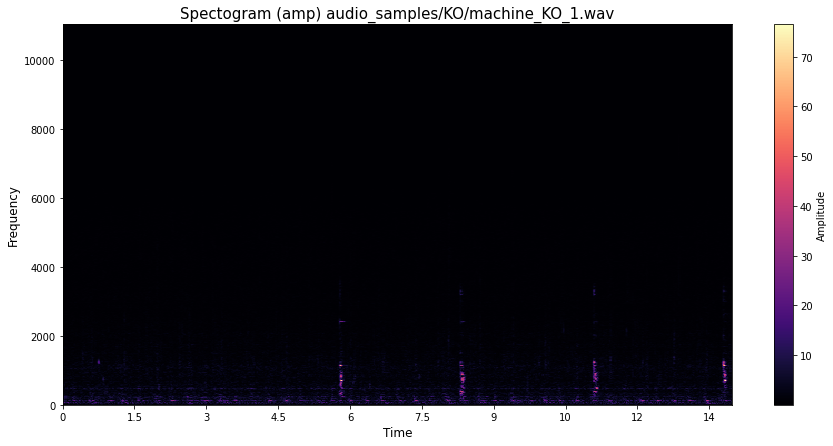

In [25]:
plt.figure(figsize=(15, 7))

# this is the number of samples in a window per fft
n_fft = 2048
# The amount of samples we are shifting after each fft
hop_length = 512
# Short-time Fourier Transformation on our audio data
audio_stftKO = librosa.core.stft(samplesKO, hop_length=hop_length, n_fft=n_fft)
# gathering the absolute values for all values in our audio_stft
spectrogramKO = np.abs(audio_stftKO)

title = "Spectogram (amp) " + audiofileKO
librosa.display.specshow(spectrogramKO,
                         sr=sr,
                         x_axis='time',
                         y_axis='hz',
                         hop_length=hop_length)
plt.colorbar(label='Amplitude')
plt.title(title, fontdict=dict(size=15))
plt.xlabel('Time', fontdict=dict(size=12))
plt.ylabel('Frequency', fontdict=dict(size=12))

outputfile3 = 'results/' + imagefnameKO + '_spectogram_amp.jpg'
plt.savefig(outputfile3, dpi=300)
plt.show()

> **As we can see most of these frequencies contribute very little to the overall amplitude of the sound**. A way for us to **visualize loudness, which is not linear but logarithmic**, is to **convert our spectrograms from amplitude to decibels.**

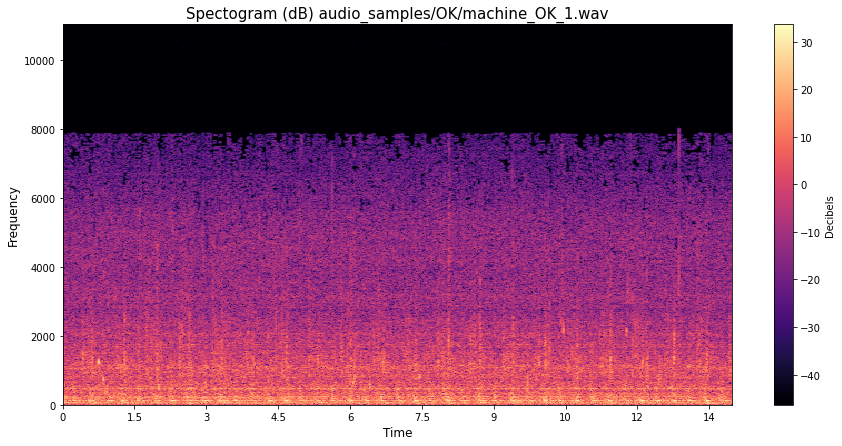

In [26]:
plt.figure(figsize=(15, 7))

# Short-time Fourier Transformation on our audio data
audio_stftOK = librosa.core.stft(samplesOK, hop_length=hop_length, n_fft=n_fft)
# gathering the absolute values for all values in our audio_stft
spectrogramOK = np.abs(audio_stftOK)
# Converting the amplitude to decibels
log_spectroOK = librosa.amplitude_to_db(spectrogramOK)

title = "Spectogram (dB) " + audiofileOK
librosa.display.specshow(log_spectroOK,
                         sr=sr,
                         x_axis='time',
                         y_axis='hz',
                         hop_length=hop_length,
                         cmap='magma')
plt.colorbar(label='Decibels')
plt.title(title, fontdict=dict(size=15))
plt.xlabel('Time', fontdict=dict(size=12))
plt.ylabel('Frequency', fontdict=dict(size=12))

outputfile4 = 'results/' + imagefnameOK + '_spectogram_db.jpg'
plt.savefig(outputfile4, dpi=300)
plt.show()

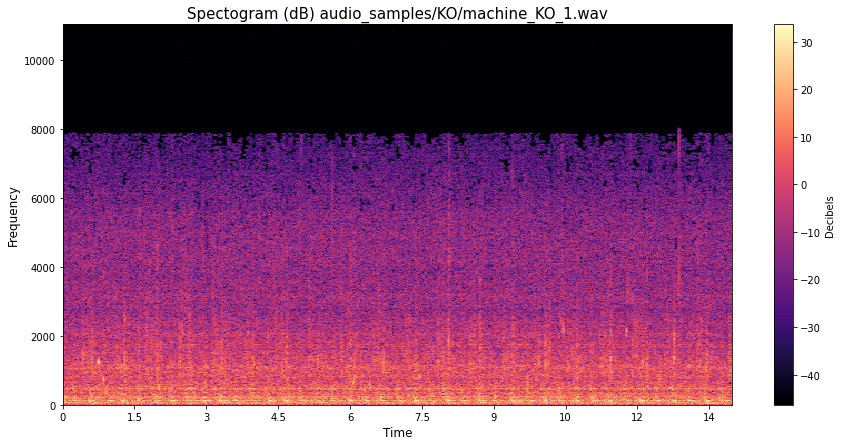

In [27]:
plt.figure(figsize=(15, 7))

# Short-time Fourier Transformation on our audio data
audio_stftKO = librosa.core.stft(samplesKO, hop_length=hop_length, n_fft=n_fft)
# gathering the absolute values for all values in our audio_stft
spectrogramKO = np.abs(audio_stftKO)
# Converting the amplitude to decibels
log_spectroKO = librosa.amplitude_to_db(spectrogramKO)

title = "Spectogram (dB) " + audiofileKO
librosa.display.specshow(log_spectroOK,
                         sr=sr,
                         x_axis='time',
                         y_axis='hz',
                         hop_length=hop_length,
                         cmap='magma')
plt.colorbar(label='Decibels')
plt.title(title, fontdict=dict(size=15))
plt.xlabel('Time', fontdict=dict(size=12))
plt.ylabel('Frequency', fontdict=dict(size=12))

outputfile4 = 'results/' + imagefnameKO + '_spectogram_db.jpg'
plt.savefig(outputfile4, dpi=300)
plt.show()

## The MEL scale

Studies have shown **that humans do not perceive frequencies on a linear scale**. <br> <br>We are better at detecting differences in low frequencies than in high frequencies. For example, **we can easily tell the difference between 500 and 1000 Hz, but we will hardly be able to tell the difference between 10,000 and 10,500 Hz,** even if the distance between the two pairs is the same.

<div class="alert alert-info"> In 1937, Stevens, Volkmann and Newmann proposed a unit of pitch such that equal distances of pitch sound equal to the listener. <b>This is called the mel scale.</b> We perform a mathematical operation on the frequencies to convert them to the mel scale. </div>

https://en.wikipedia.org/wiki/Mel_scale

<img src="https://www.sfu.ca/sonic-studio-webdav/handbook/Graphics/Mel.gif">

On this DB scale, 0 dB is total silence. 
From there, measurement units increase exponentially. 10 dB is 10 times louder than 0 dB, 20 dB is 100 times louder and 30 dB is 1000 times louder. On this scale, a sound above 100 dB starts to become unbearably loud.

**We can see that, to deal with sound in a realistic manner, it is important for us to use a logarithmic scale via the Mel Scale and the Decibel Scale when dealing with Frequencies and Amplitudes in our data.**
That is exactly what the Mel Spectrogram is intended to do.

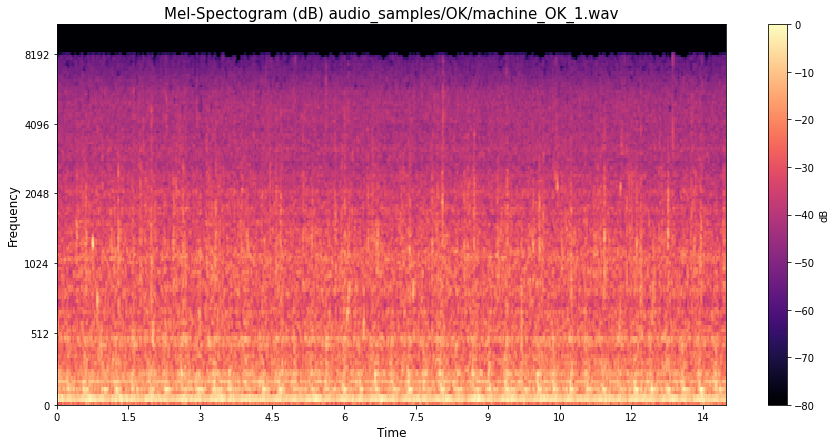

In [28]:
plt.figure(figsize=(15, 7))

mel_signalOK = librosa.feature.melspectrogram(y=samplesOK,
                                              sr=sr,
                                              hop_length=hop_length,
                                              n_fft=n_fft)
spectrogramOK = np.abs(mel_signalOK)
power_to_dbOK = librosa.power_to_db(spectrogramOK, ref=np.max)

librosa.display.specshow(power_to_dbOK,
                         sr=sr,
                         x_axis='time',
                         y_axis='mel',
                         cmap='magma',
                         hop_length=hop_length)

title = "Mel-Spectogram (dB) " + audiofileOK

plt.title(title, fontdict=dict(size=15))
plt.xlabel('Time', fontdict=dict(size=12))
plt.ylabel('Frequency', fontdict=dict(size=12))
plt.colorbar(label='dB')

outputfile5 = 'results/' + imagefnameOK + '_melspectogram_db.jpg'
plt.savefig(outputfile5, dpi=300)
plt.show()

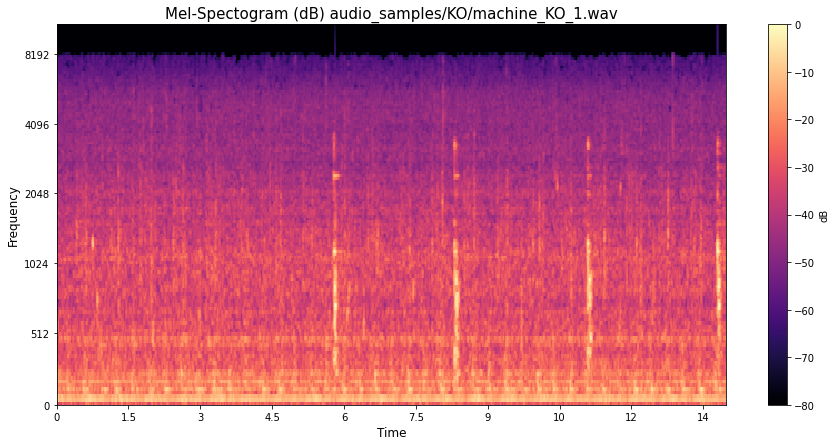

In [29]:
plt.figure(figsize=(15, 7))

mel_signalKO = librosa.feature.melspectrogram(y=samplesKO,
                                              sr=sr,
                                              hop_length=hop_length,
                                              n_fft=n_fft)
spectrogramKO = np.abs(mel_signalKO)
power_to_dbKO = librosa.power_to_db(spectrogramKO, ref=np.max)

librosa.display.specshow(power_to_dbKO,
                         sr=sr,
                         x_axis='time',
                         y_axis='mel',
                         cmap='magma',
                         hop_length=hop_length)

title = "Mel-Spectogram (dB) " + audiofileKO

plt.title(title, fontdict=dict(size=15))
plt.xlabel('Time', fontdict=dict(size=12))
plt.ylabel('Frequency', fontdict=dict(size=12))
plt.colorbar(label='dB')

outputfile5 = 'results/' + imagefnameKO + '_melspectogram_db.jpg'
plt.savefig(outputfile5, dpi=300)
plt.show()

## We can see some anomalies in time 5.5, 8, 11 and 14.5 secs approximatively.

> End. You can go to the next notebook

Note: All these Python notebooks were made for demo purposes. They were not designed for production usage. Some feature can be currently in public preview. This preview version is provided without a service-level agreement. Certain features might not be supported or might have constrained capabilities. For more information, see Supplemental Terms of Use for Microsoft Azure Previews. https://azure.microsoft.com/en-us/support/legal/preview-supplemental-terms/